(This notebook was developed by Connor Waits)

# Keras Neural Net Tutorial

In this tutorial you will do preprocessing steps on the scikit-learn UCI ML Wine Data Set and compile, train, and evaluate a neural net with keras. Keras is a multi-framework API that provides high-level abstractions of deep learning frameworks. We will be using tensorflow for our deep learning framework here. 

In [1]:
from sys impor

import tensorflow
import keras
import numpy as np
from sklearn import datasets
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

ModuleNotFoundError: No module named 'tensorflow'

## Preprocessing
Before building our model, we will load the dataset and do some simple preprocessing consisting of splitting the data into a train and test split and normalizing the data. Scikit-learn is the package that we are using to do the preprocessing. It's a great package that has many out of the box machine learning architectures, as well as many tools for preprocessing, tuning, and data visualization. 

It is important to split data into training and testing subsets before doing any kind of scaling and only fit the scaler onto the training subset. Then the fitted scaler can be used to scale the testing subset. By fitting a scaler onto the global dataset, the training set will learn information about the test set and produce an overly optimistic model. This is called data leakage.

Before we do any preprocessing, let's take a closer look at the wine dataset. We will load the dataset into a pandas DataFrame and then make a plot showing the correlations between variables and compare the sizes of the 3 classes.  

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            10.6  30.0    19.5   3.3
    Ma

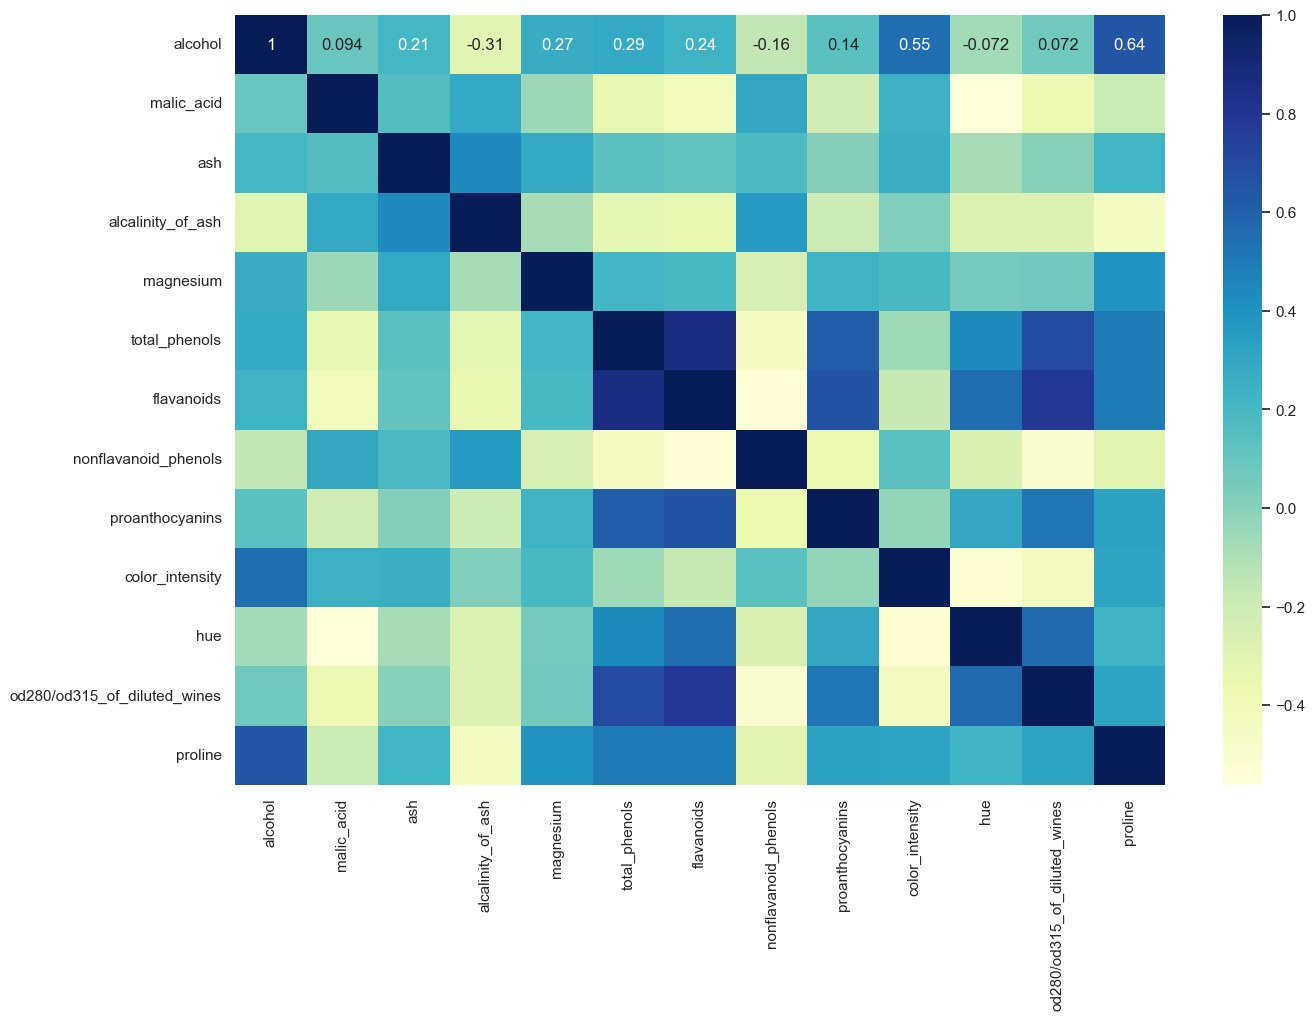


Number of samples per class: [59 71 48]



In [26]:
dataset = datasets.load_wine()
print(dataset.DESCR)

df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df['label'] = dataset.target
print(df)

print(df[dataset.feature_names])
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(df[dataset.feature_names].corr(), annot=True, cmap="YlGnBu")
plt.show()

print()
print(f'Number of samples per class: {np.bincount(df["label"])}')
print()

X_train, X_test, y_train, y_test = model_selection.train_test_split(df[dataset.feature_names], df['label'], test_size=0.25, random_state=42)

With the data split, let's now scale the data. Some sort of scaling/normalization is needed for most machine learning algorithms. The two most common are z-score scaling and normalization. z-score scaling consists of scaling data such that the distribution has a mean of zero and a standard deviation of 1. This is appropriate when the distribution is known to be somehwat Gaussian. In other cases, normalization, also called min/max scaling, can be used to bring the data from it's original range to [0, 1]. For applications of ML to physics, this would typically be appropriate. 

In [27]:
scaler = preprocessing.MinMaxScaler()
print("Before Scaling")
print(X_train[:5])
print("After Scaling")
X_train = scaler.fit_transform(X_train)
print(pd.DataFrame(X_train, columns = dataset.feature_names)[:5])
#now scale test features ONLY
X_test = scaler.transform(X_test)

Before Scaling
     alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
9      13.86        1.35  2.27               16.0       98.0           2.98   
18     14.19        1.59  2.48               16.5      108.0           3.30   
150    13.50        3.12  2.62               24.0      123.0           1.40   
94     11.62        1.99  2.28               18.0       98.0           3.02   
74     11.96        1.09  2.30               21.0      101.0           3.38   

     flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
9          3.15                  0.22             1.85             7.22  1.01   
18         3.93                  0.32             1.86             8.70  1.23   
150        1.57                  0.22             1.25             8.60  0.59   
94         2.26                  0.17             1.35             3.25  1.16   
74         2.14                  0.13             1.65             3.21  0.99   

     od280/od315_of_dil

### Principal Component Analysis (PCA)
For convience, we are doing the PCA on the normalized training data only so that we do not have to fit another scaler. In practice, you should scale and do PCA on the entire dataset.

PC	variance
---	--------
PC_1:	0.412
PC_2:	0.176
PC_3:	0.093
PC_4:	0.073
PC_5:	0.056
PC_6:	0.047
PC_7:	0.041
PC_8:	0.025
PC_9:	0.024
PC_10:	0.02
PC_11:	0.014
PC_12:	0.012
PC_13:	0.008


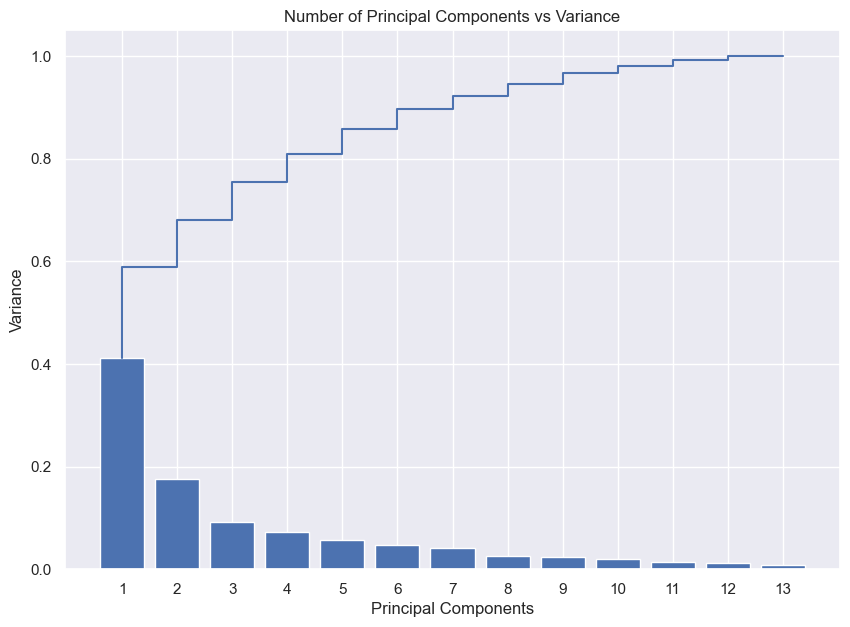

In [28]:
pc_range = np.arange(1,X_train.shape[1] + 1)
pca = PCA(n_components=None)
pca.fit(X_train)

plt.figure(figsize=(10,7))
plt.bar(pc_range, pca.explained_variance_ratio_)
plt.step(pc_range, np.cumsum(pca.explained_variance_ratio_))
plt.xticks(pc_range)
plt.xlabel("Principal Components")
plt.ylabel("Variance")
_ = plt.title("Number of Principal Components vs Variance")

print("PC\tvariance")
print("---\t--------")
for i,k in  enumerate(pca.explained_variance_ratio_):
    print('PC_{}:\t{}'.format(i+1, round(k, 3)))

## The Neural Net Class
Class for keras neural net.
The class takes the input shape, the dimension of the output, a list of nodes per layer, the activation to use, the opimizer, and the loss function to minimize.

In [29]:
class NeuralNet:
    def __init__(self, input_shape, output_dim, layers=[10, 10], activation = 'relu', 
                 optimizer="adam", lossfn="sparse_categorical_crossentropy", regularizer=None):
        self.input_shape = input_shape
        self.output_dim  = output_dim
        self.layers = layers
        self.activation = activation
        self.optimizer = optimizer
        self.lossfn = lossfn
        self.regularizer = regularizer

        self.model = keras.models.Sequential()
        self.model.add(keras.layers.InputLayer(self.input_shape))
        for nodes in layers:
            self.model.add(keras.layers.Dense(nodes, activation=self.activation, kernel_regularizer=self.regularizer))
        #use softmax activation for last layer to get class probabities as outputs
        self.model.add(keras.layers.Dense(self.output_dim, activation='softmax'))

        self.model.compile(optimizer=self.optimizer, loss=self.lossfn)
        self.model.summary()

    def fit(self, x, y, epochs=25, batch_size=32, callbacks=[keras.callbacks.ProgbarLogger()]):#BaseLogger()]):
        self.model.fit(x=x, y=y, epochs=epochs, batch_size=batch_size, callbacks=callbacks)

    def save_weights(self, path=None, tag=""):
        if path is None: 
            path = os.getcwd()
        if tag != "": 
            tag = "_"+tag
        self.model.save_weights(os.path.join(path, f"model_weights{tag}.h5"))

    def load_weights(self, path=None, tag=""):
        if path is None: 
            path = os.getcwd()
        if tag != "": 
            tag = "_"+tag
        self.model.load_weights(os.path.join(path, f"model_weights{tag}.h5"))
        return self

    def predict(self, input):
        return self.model.predict(input)


## Training and evaluating the Network
First, we will instantiate a neural net with the desired hyperparameters. To train the network, only the fit method defined in the neural net needs to be called on the training data. After training, we can then save the weights to load later

In [49]:
#first clear any previous trainings
keras.backend.clear_session()
params = {'input_shape':len(dataset.feature_names), 'output_dim':df['label'].nunique(), 'layers':[10, 10]}
#uncomment line below to add L1 regularizer
#params['regularizer'] = 'l1'
nn = NeuralNet(**params)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                140       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________


In [50]:
nn.fit(x=X_train, y=y_train, epochs=50)

Epoch 1/50
5/5 [==============================] - 0s 31ms/sample - loss: 1.6902
Epoch 2/50
5/5 [==============================] - 0s 549us/sample - loss: 1.6696
Epoch 3/50
5/5 [==============================] - 0s 608us/sample - loss: 1.6522
Epoch 4/50
5/5 [==============================] - 0s 1ms/sample - loss: 1.6363
Epoch 5/50
5/5 [==============================] - 0s 834us/sample - loss: 1.6212
Epoch 6/50
5/5 [==============================] - 0s 699us/sample - loss: 1.6074
Epoch 7/50
5/5 [==============================] - 0s 907us/sample - loss: 1.5945
Epoch 8/50
5/5 [==============================] - 0s 630us/sample - loss: 1.5822
Epoch 9/50
5/5 [==============================] - 0s 753us/sample - loss: 1.5702
Epoch 10/50
5/5 [==============================] - 0s 624us/sample - loss: 1.5586
Epoch 11/50
5/5 [==============================] - 0s 866us/sample - loss: 1.5470
Epoch 12/50
5/5 [==============================] - 0s 626us/sample - loss: 1.5357
Epoch 13/50
5/5 [===========

Now that the model is trained, let's see how we would save it for later use and re-load it.

In [51]:
nn.save_weights(tag='test')

nn = NeuralNet(**params)

nn.load_weights(tag='test')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                140       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 3)                 33        
                                                                 
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________


Now let's evaluate the model by calling the predict method on the testing data

In [52]:
pred_probs = nn.predict(X_test)
print(pred_probs)

2/2 [==============================] - 0s 962us/step
[[0.6039536  0.32867166 0.06737478]
 [0.34352738 0.41449046 0.24198216]
 [0.39946404 0.40544245 0.19509353]
 [0.24795894 0.3752512  0.37678984]
 [0.6252615  0.31133023 0.06340827]
 [0.29643688 0.40844414 0.2951189 ]
 [0.49682647 0.37722987 0.12594365]
 [0.2452871  0.36274695 0.3919659 ]
 [0.24232182 0.36942273 0.38825548]
 [0.6192244  0.31762195 0.06315357]
 [0.46507263 0.39887404 0.13605328]
 [0.57869995 0.3372105  0.08408952]
 [0.26050633 0.3801383  0.3593554 ]
 [0.7091463  0.25628728 0.03456645]
 [0.3652843  0.41378698 0.22092877]
 [0.38806665 0.4201223  0.19181101]
 [0.42067814 0.39883757 0.18048434]
 [0.2973653  0.38723782 0.31539696]
 [0.42910874 0.41389415 0.15699708]
 [0.54805064 0.35385627 0.09809301]
 [0.689087   0.2700967  0.04081636]
 [0.36267364 0.42087927 0.21644707]
 [0.607067   0.32015762 0.07277539]
 [0.52568465 0.36717623 0.10713911]
 [0.23837668 0.36822066 0.39340273]
 [0.6730506  0.28072774 0.04622162]
 [0.2678278

## Metrics
The predict method returns an array with 3 elements, which correspond to the class probabilities for the wine to originate from cultivar 0, 1, or 2. We can pass the the truth-level class information with the predictions to some scikit-learn metrics functions to learn how well the model performed.

In [53]:
y_pred = np.argmax(pred_probs, axis=1)
print(y_pred)
print(classification_report(y_test, y_pred, labels=[0,1,2]))

[0 1 1 2 0 1 0 2 2 0 0 0 1 0 1 1 0 1 0 0 0 1 0 0 2 0 1 0 0 2 1 0 2 2 1 0 0
 0 0 2 0 0 0 0 0]
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        20
           1       0.82      0.60      0.69        15
           2       1.00      0.80      0.89        10

    accuracy                           0.82        45
   macro avg       0.86      0.80      0.82        45
weighted avg       0.84      0.82      0.81        45



### Confusion Matrix
Now let's make the confusion matrix

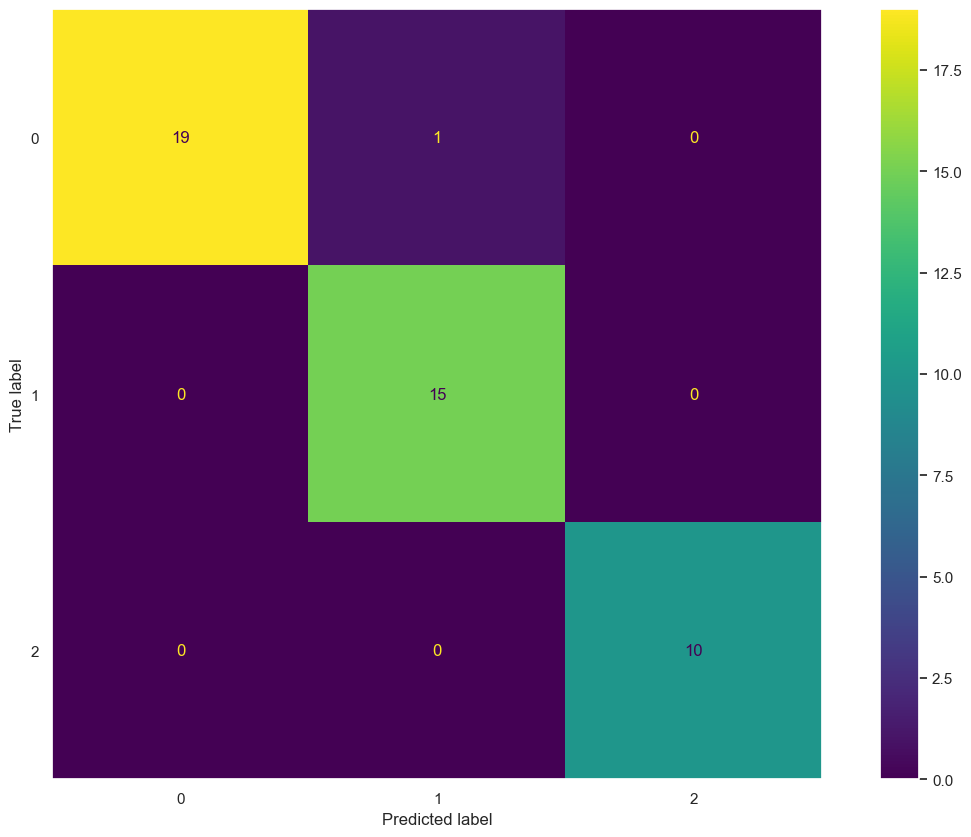

In [47]:
cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])#, cmap = plt.get_cmap('Blues'))
disp.plot()
plt.grid(False)
plt.show()

### The ROC Curve

(45,)
(45, 3)
[[1 0 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]]
[1, 2]
[0, 2]
[0, 1]


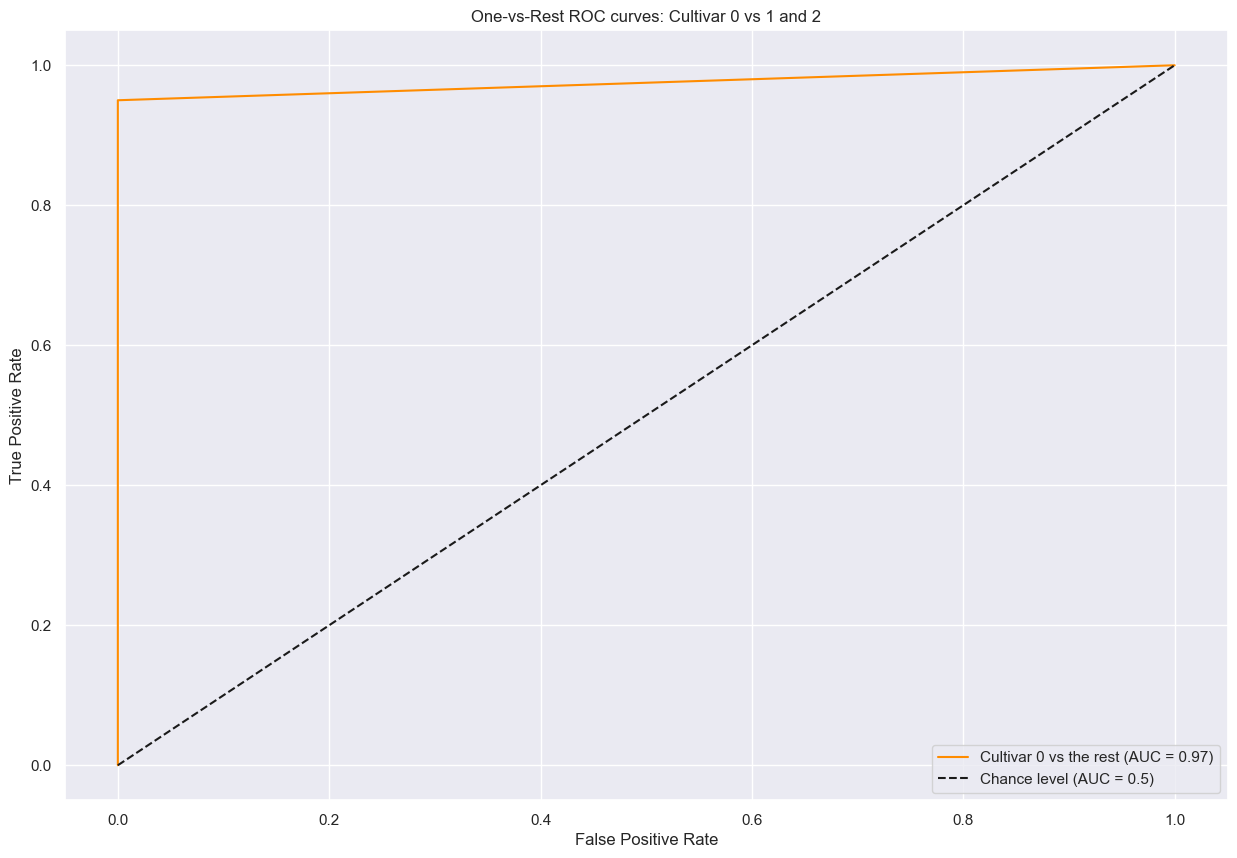

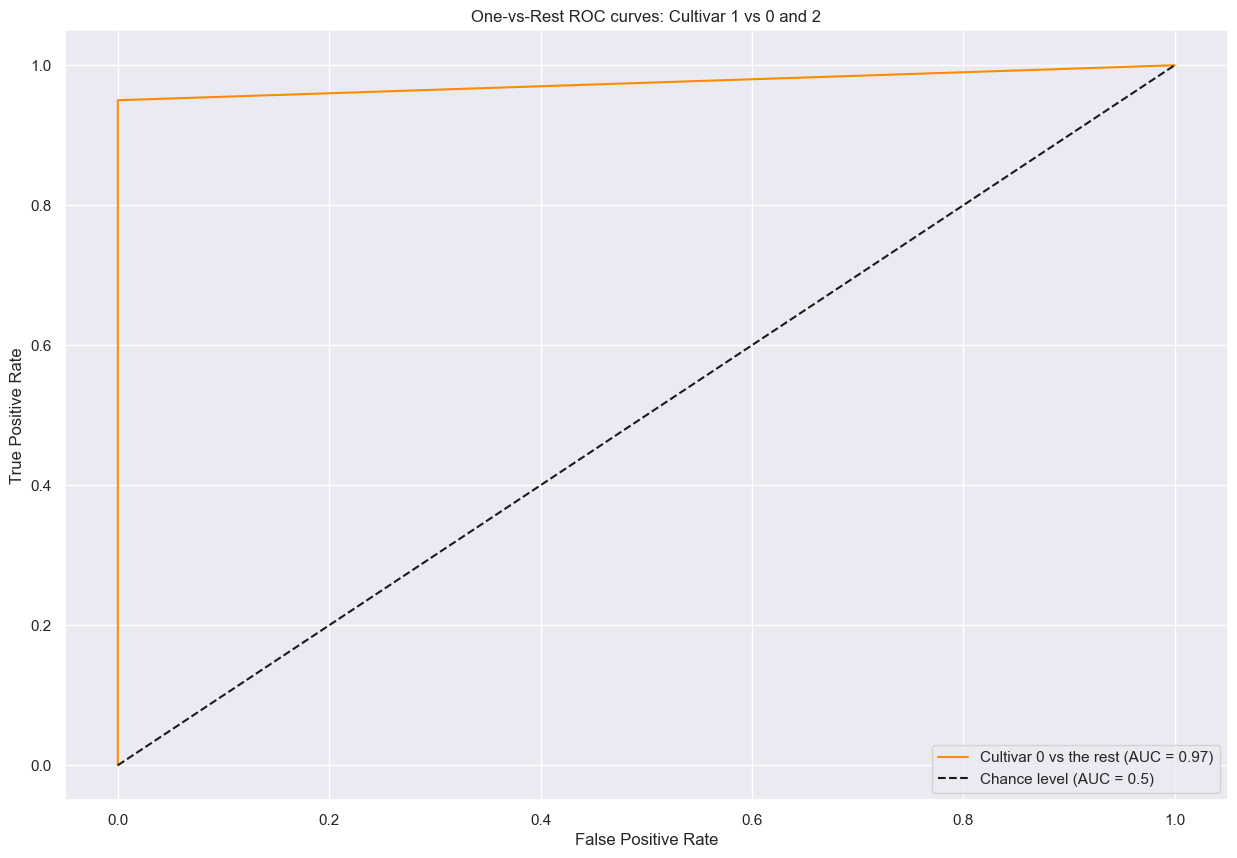

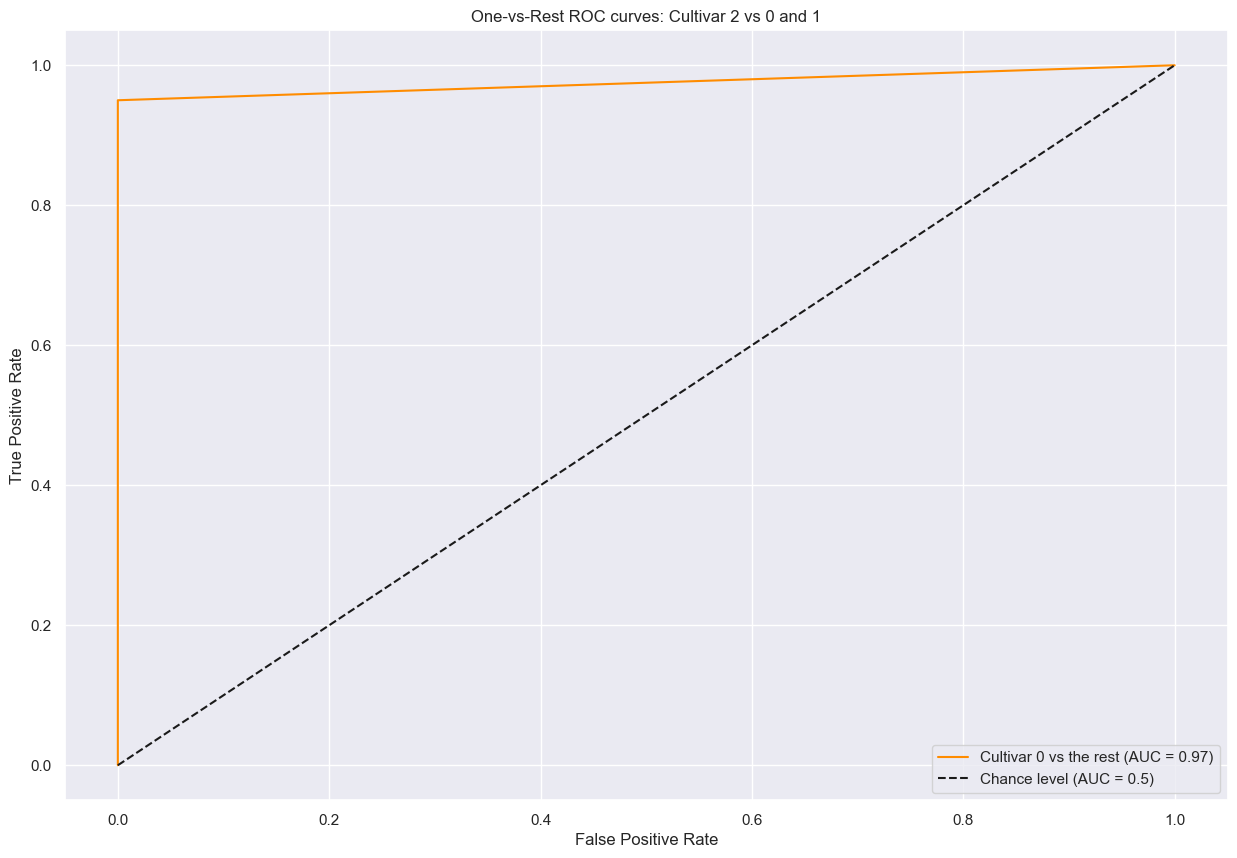

In [48]:
encoder = preprocessing.LabelBinarizer().fit(y_test)
y_onehot_test = encoder.transform(y_test)
y_onehot_pred = encoder.transform(y_pred)
print(y_pred.shape)
print(y_onehot_pred.shape)
print(y_onehot_pred)

def ROC_Display(y_test, y_pred, cultivar):
    others = [i for i in [0,1,2] if i != cultivar ]
    print(others)
    display = RocCurveDisplay.from_predictions(
        y_onehot_test[:, 0],
        y_onehot_pred[:, 0],
        name=f"Cultivar {0} vs the rest",
        color="darkorange",
        plot_chance_level=True,
    )
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"One-vs-Rest ROC curves: Cultivar {cultivar} vs {others[0]} and {others[1]}"
    )
    return

for i in range(3):
    ROC_Display(y_onehot_test, y_onehot_pred, i)

Now clear the output for all cells and change the number of layers in the network to [10, 10] and compare the metrics to the original [100, 100] network. There are several rules of thumb when determining the size of a network. 

You can also uncommment the line that adds a regularizer to the network.

The more complex the relationships between the features in your dataset and the target variable is, the deeper (more layers) your network needs to be to accurately learn the training data. However, creating a network that is too deep will result in overfitting to your training data set. 

### Hyperparamter Tuning
Hyperparameter tuning can be done with the use of the keras tuner https://keras.io/guides/keras_tuner/getting_started/ or can do "by hand"

In [56]:
params = {
    'optimizer':['adam', 'adamax'],

    'filters':[
        [5, 5, 5, 5],
        [10, 10],
        [15],
        [7, 7, 7]
    ],

    'activation':['relu', 'elu', 'sigmoid']
    }

def combinations(params):
    keys, values = zip(*params.items())
    permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
    return permutations_dicts

combos = combinations(params)
print(combos)

[{'optimizer': 'adam', 'filters': [5, 5, 5, 5], 'activation': 'relu'}, {'optimizer': 'adam', 'filters': [5, 5, 5, 5], 'activation': 'elu'}, {'optimizer': 'adam', 'filters': [5, 5, 5, 5], 'activation': 'sigmoid'}, {'optimizer': 'adam', 'filters': [10, 10], 'activation': 'relu'}, {'optimizer': 'adam', 'filters': [10, 10], 'activation': 'elu'}, {'optimizer': 'adam', 'filters': [10, 10], 'activation': 'sigmoid'}, {'optimizer': 'adam', 'filters': [15], 'activation': 'relu'}, {'optimizer': 'adam', 'filters': [15], 'activation': 'elu'}, {'optimizer': 'adam', 'filters': [15], 'activation': 'sigmoid'}, {'optimizer': 'adam', 'filters': [7, 7, 7], 'activation': 'relu'}, {'optimizer': 'adam', 'filters': [7, 7, 7], 'activation': 'elu'}, {'optimizer': 'adam', 'filters': [7, 7, 7], 'activation': 'sigmoid'}, {'optimizer': 'adamax', 'filters': [5, 5, 5, 5], 'activation': 'relu'}, {'optimizer': 'adamax', 'filters': [5, 5, 5, 5], 'activation': 'elu'}, {'optimizer': 'adamax', 'filters': [5, 5, 5, 5], 'act

## The End
That's the basics of how to build a neural net and evaluate it in Keras. We did not cover some other topics like regularization or hyperparameter tuning, so that can be done next time.